In [1]:
#@title # Setting up the environment { vertical-output: true, display-mode: "form" }

###################
#####  SETUP  #####
###################

#@title Setting up project paths
import os

colab_setup = False #@param {type:"boolean"}
PROJECT_PATH = "/content/drive/MyDrive/TWM/Graduation-Project/" #@param {"type":"string"}

if colab_setup:
    from google.colab import drive
    print("Mounting Google Drive...", end="", flush=True)
    drive.mount('/content/drive')
    print("Done")

# else:
#     # set this to the parent directory of the whole project
#     PROJECT_PATH = rf"C:\Users\{os.environ['USERNAME']}\Graduation-Project"

print("PROJECT_PATH:", PROJECT_PATH)
os.chdir(PROJECT_PATH)
os.listdir()

PROJECT_PATH: C:\Users\LAPTOP\Graduation-Project


['.git',
 '.gitignore',
 '.vscode',
 'chatbot-env',
 'DataEngineering',
 'Dependencies',
 'FineTuneing',
 'hierarchy.txt',
 'requirements.txt',
 'Testing Interface.ipynb',
 'Utils']

In [2]:
#@markdown Importing modules
from collections import Counter
import functools
import glob
import re
import random
import string

from colorama import Fore, Back, Style
import contextualSpellCheck
from IPython.display import display
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
import spacy
from spellchecker import SpellChecker
from unidecode import unidecode
from wordcloud import WordCloud

import Utils.helperFunctions as helperFunctions
import Utils.dialogueUtils as dialogueUtils

In [3]:
#@markdown Configuration

###################
##### CONFIGS #####
###################

# the merged dataset is the combined dataset after classifying 
# all the datasets and merging the most classified categories into a single dataset
PATH_TO_MERGED_DATASET = "DataEngineering/MergedDataset/merged_dataset.csv" # @param {type:"string"}

SEED = 511 #@param {type:"integer"}
print("Setting the project seed.. ")
def seed_everything(seed=SEED):
    print("environment seed was reset: seed=", seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
seed_everything()

MATPLOTLIB_STYLE = "seaborn-v0_8" #@param {type:"string"}
plt.style.use(MATPLOTLIB_STYLE)

print("Done")

Setting the project seed.. 
environment seed was reset: seed= 511
Done


In [4]:
#@title # Environment Watermark
%load_ext watermark
%watermark --author "Mohamed Hisham" --email "Mohamed00Hisham@gmail.com" --github_username "Mhmd-Hisham"
%watermark
%watermark --iversions

Author: Mohamed Hisham

Github username: Mhmd-Hisham

Email: Mohamed00Hisham@gmail.com

Last updated: 2022-09-28T07:25:51.035421+02:00

Python implementation: CPython
Python version       : 3.9.5
IPython version      : 8.5.0

Compiler    : MSC v.1928 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 165 Stepping 2, GenuineIntel
CPU cores   : 12
Architecture: 64bit

spacy               : 3.4.1
matplotlib          : 3.6.0
contextualSpellCheck: 0.4.3
numpy               : 1.23.3
re                  : 2.2.1
sys                 : 3.9.5 (tags/v3.9.5:0a7dcbd, May  3 2021, 17:27:52) [MSC v.1928 64 bit (AMD64)]
pandas              : 1.5.0
seaborn             : 0.12.0



# Inspecting The Distributions In The Merged Dataset

In [5]:
# @markdown ## Loading The Merged Dataset

# The index of the dataframe is not from 1 to df.shape[0]
# each index refers to the index of the dialogue in the original csv file 
# that the dialogue came from
merged_df = pd.read_csv(PATH_TO_MERGED_DATASET, index_col=0)

display(merged_df)
display(merged_df.info())

,dialogue,dataset,topic,subtopic1,subtopic2
4,"#Person1#: Watsup, ladies! Y'll looking'fine t...",DialogSum,Arts & Entertainment,NaN,NaN
12,#Person1#: Did Bean send these dirty jokes to ...,DialogSum,Arts & Entertainment,Humor,NaN
14,#Person1#: What kind of music do you like list...,DialogSum,Arts & Entertainment,Music & Audio,NaN
24,#Person1#: Out of every movie that you've seen...,DialogSum,Arts & Entertainment,Movies,NaN
25,#Person1#: What's all the security check about...,DialogSum,Arts & Entertainment,NaN,NaN
...,...,...,...,...,...
9845,#Person1#:Can I get a car for 4 on Friday nigh...,MSR-E2E,Autos & Vehicles,NaN,NaN
9911,#Person1#:April 16th at 4pm\n#Person2#:How man...,MSR-E2E,Autos & Vehicles,NaN,NaN
9948,#Person1#:Please send a fuel efficient vehicle...,MSR-E2E,Autos & Vehicles,NaN,NaN
10013,#Person1#:I need a ride to Hamm's Tires on S C...,MSR-E2E,Autos & Vehicles,Vehicle Parts & Services,Vehicle Parts & A


<class 'pandas.core.frame.DataFrame'>
Int64Index: 123362 entries, 4 to 10044
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   dialogue   123362 non-null  object
 1   dataset    123362 non-null  object
 2   topic      123362 non-null  object
 3   subtopic1  81833 non-null   object
 4   subtopic2  13142 non-null   object
dtypes: object(5)
memory usage: 5.6+ MB


None

In [6]:
# @title ## Merged Dataset Statistics

dataset_names = merged_df['dataset'].unique()
topic_names = merged_df['topic'].unique()

merged_stats_df = merged_df.groupby('topic').apply(dialogueUtils.get_stats)
merged_stats_df = merged_stats_df.apply(pd.Series).astype(int)
merged_stats_df = merged_stats_df.loc[topic_names]
merged_stats_df.loc['Total'] = dialogueUtils.get_stats(merged_df)

helperFunctions.pprint_df(merged_stats_df)

,# dialogues,# utterances,avg # turns in a dialogue,avg # words in a turn
topic,,,,
Arts & Entertainment,67K,933K,13,10
Food & Drink,21K,351K,16,9
Travel,20K,387K,18,10
Sports,6K,82K,12,8
People & Society,3K,27K,7,12
Autos & Vehicles,3K,63K,19,9
Total,123K,1.85M,14,9


In [7]:
# @title ## Number of Topics in Each Dataset

DATASET_NAMES = merged_df['dataset'].unique()
TOPIC_NAMES = merged_df['topic'].unique()

def get_counts_df(df):
    counts_df = df.groupby('dataset')
    counts_df = counts_df.apply(lambda df: df['topic'].value_counts().to_frame().T)
    counts_df = counts_df.droplevel(1).fillna(0)
    counts_df = counts_df.loc[DATASET_NAMES][TOPIC_NAMES] # reorder
    counts_df['Total'] = counts_df.sum(axis=1)
    counts_df.loc['Total'] = counts_df.sum(axis=0)
    return counts_df

counts_df = get_counts_df(merged_df)
helperFunctions.pprint_df(counts_df)

,Arts & Entertainment,Food & Drink,Travel,Sports,People & Society,Autos & Vehicles,Total
dataset,,,,,,,
DialogSum,1K,741,442,289,288,127,3K
DailyDialog,1K,619,319,205,226,103,2K
Cornell Movie--Dialogs Corpus,16K,385,106,274,1K,171,18K
Commonsense-Dialogues,1K,256,28,162,127,91,2K
EmpatheticDialogues,2K,475,144,354,501,249,4K
MultiWOZ 2.2,184,2K,3K,3,58,59,6K
Taskmaster-2,4K,3K,3K,2K,26,0,14K
MetaLWOZ,5K,2K,1K,1K,536,123,10K
Taskmaster-1,2K,6K,1K,7,4,1K,11K


array([<AxesSubplot: title={'center': 'Contribution Of Each Dataset To The Merged Dataset'}, xlabel='Number of Dialogues', ylabel='dataset'>,
       <AxesSubplot: title={'center': 'Distribution Of Topics In The Merged Dataset'}, xlabel='Number of Dialogues'>],
      dtype=object)

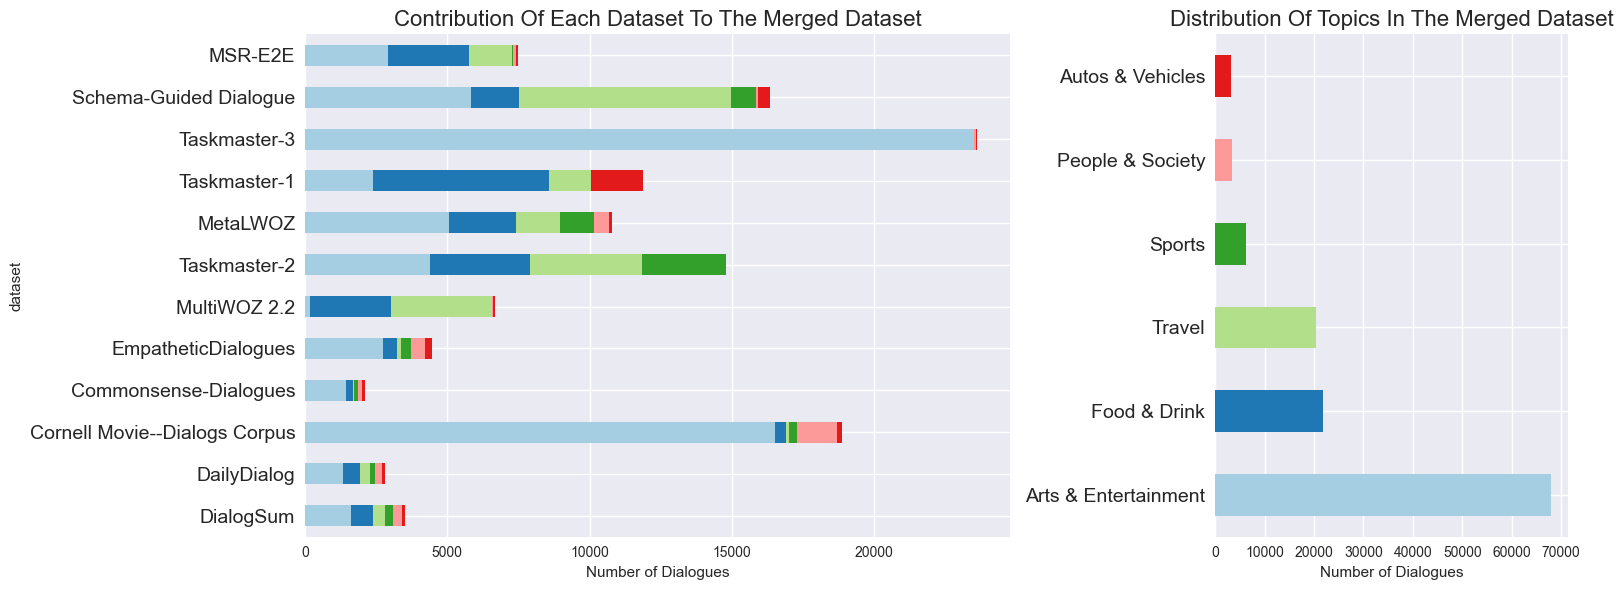

In [8]:
# @title ## Merged Dataset Distributions

colors = sns.color_palette("rocket")
colors = sns.color_palette("Paired")

def plot_df_distributions(df, title, fig=None, axes=None, add_labels=True):
    if fig==None:
        fig, axes = plt.subplots(
            ncols=2, 
            figsize=(16, 6), 
            gridspec_kw={'width_ratios': [2, 1]}
        )

    counts_df = get_counts_df(df)
    contribution_df = counts_df.drop(columns=['Total'], index='Total')
    contribution_df.plot(
        use_index=True, 
        kind='barh', 
        stacked=True, 
        ax=axes[0], 
        color=colors,
        legend=False,
    )


    counts_df.loc['Total'][:-1].plot(
        kind='barh', 
        color=colors[:len(TOPIC_NAMES)], 
        ax=axes[1]
    )

    axes[0].set_title(title)
    axes[1].set_title(title)

    if add_labels:
        axes[0].set_title(
            f"Contribution Of Each Dataset To The {title}", 
            fontsize=16)

        axes[1].set_title(
            f'Distribution Of Topics In The {title}', 
            fontsize=16
        )
        axes[0].set_yticks(range(len(DATASET_NAMES)))
        axes[0].set_yticklabels(DATASET_NAMES, fontsize=14)
        axes[1].set_yticks(range(len(TOPIC_NAMES)))
        axes[1].set_yticklabels(TOPIC_NAMES, fontsize=14)

        axes[0].set_xlabel('Number of Dialogues')
        axes[1].set_xlabel('Number of Dialogues')
    else:
        axes[0].get_yaxis().set_ticks([])
        axes[1].get_yaxis().set_ticks([])

    plt.tight_layout()
    # plt.show()
    return axes

plot_df_distributions(merged_df, "Merged Dataset")

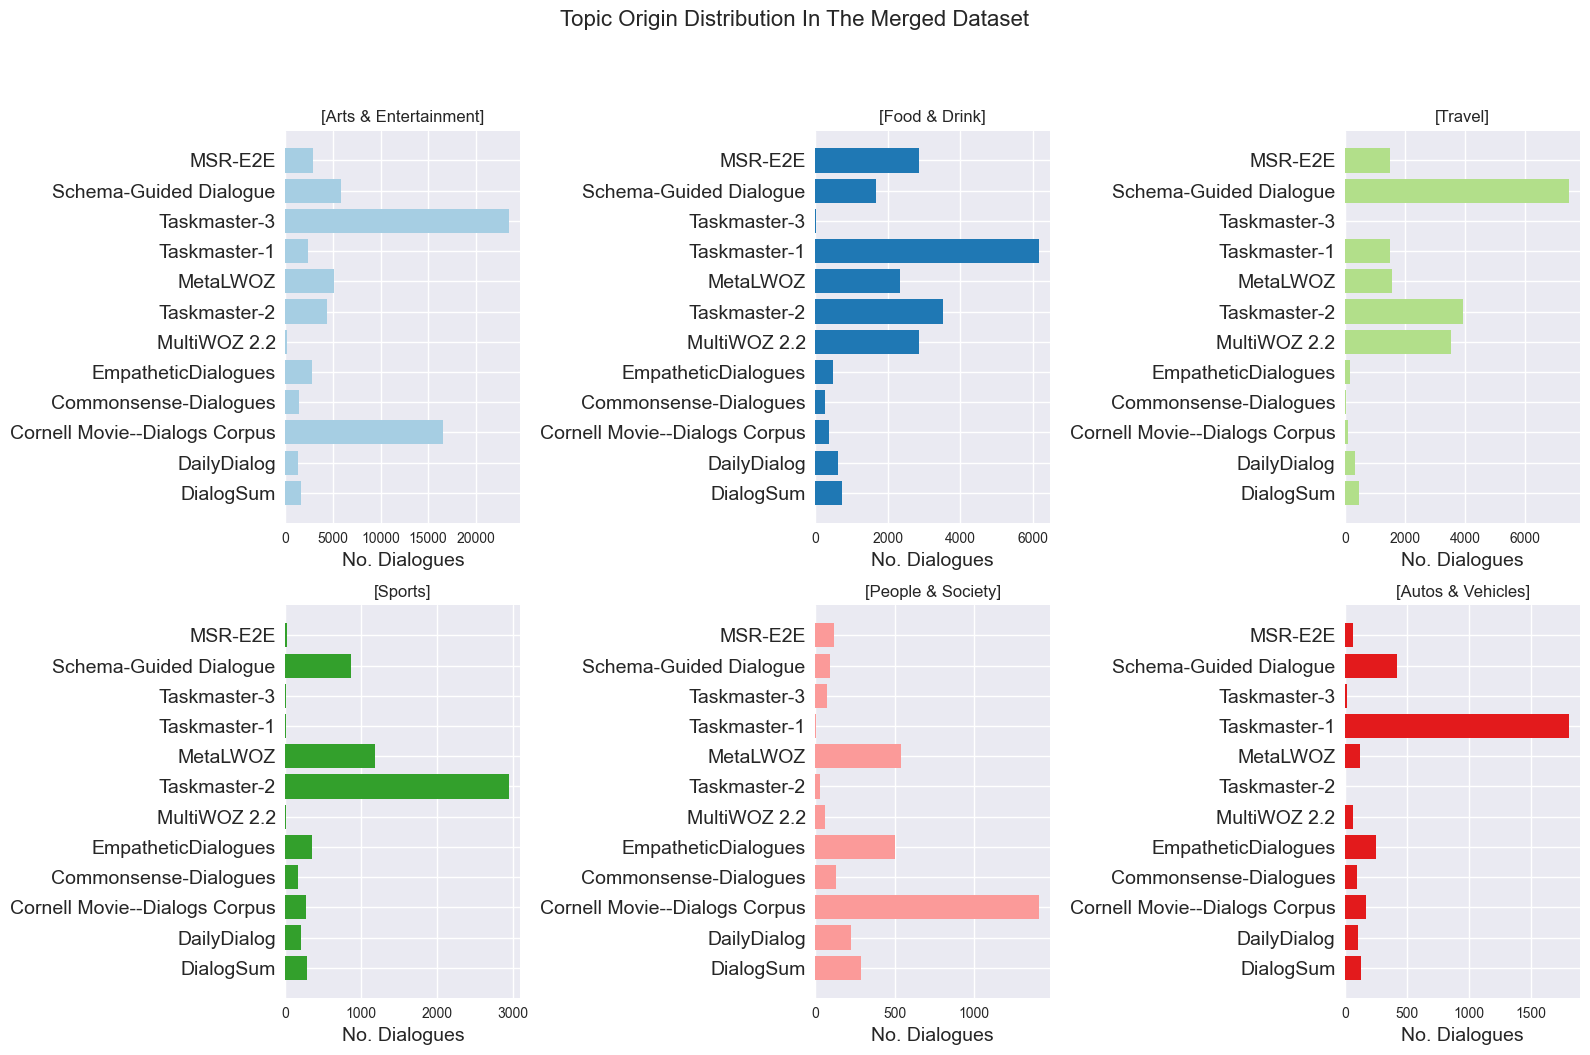

In [9]:
# @title ## Topic Origin Distributions
n_topics = len(topic_names)

grouped_df = merged_df.groupby(by=['topic', 'dataset']).apply(len)

# max_count = grouped_df.max()
# max_count = merged_df.shape[0]

ncols = 3
nrows = int(np.ceil(n_topics/ncols))
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16,5*nrows))
for ax in axes.flat:
    ax.axis('off')

for i, (ax, topic) in enumerate(zip(axes.flat, topic_names)):
    ax.axis('on')
    topic_df = merged_df[merged_df['topic']==topic]
    counts = [topic_df[topic_df['dataset']==d].shape[0] for d in dataset_names]
    max_count = sum(counts)

    ax.barh(dataset_names, counts, color=colors[i])
    ax.set_yticks(range(len(dataset_names)))
    ax.set_yticklabels(dataset_names, fontsize=14)

    ax.set_title(f"[{topic}]", fontsize=12)#, y=-0.2)
    ax.set_xlabel("No. Dialogues", fontsize=14)
    # ax.set_xlim(0, max_count)

fig.suptitle("Topic Origin Distribution In The Merged Dataset", fontsize=16, y=1.05)

plt.tight_layout()
plt.show()

# Preprocessing

## Transliteration: handling non-ASCII characters



In [10]:
#@markdown ###Counting Non-ASCII characters

# define a normal charset
# normal charset contains digits, letters, punctuation, etc..
normal_charset = set(string.printable)

# get the unique characters from the given dataframe
get_charset = lambda df: set(''.join(df['dialogue']))

# get the non normal charset 
# emojis are not considered of the normal charset
get_non_ascii_charset = lambda charset: charset-normal_charset

# printing the number of characters in every dataset
charsets = merged_df.groupby(['dataset']).apply(get_charset)

non_ascii_charsets = charsets.apply(get_non_ascii_charset)
frames = [
    charsets.apply(len).to_frame('# chars'),
    non_ascii_charsets.apply(len).to_frame("# non-ascii chars"),
    non_ascii_charsets.apply(lambda s: ''.join(s)).to_frame("non-ascii chars")
]

charsets_stats_df = pd.concat(frames, axis=1)
charsets_stats_df

,# chars,# non-ascii chars,non-ascii chars
dataset,,,
Commonsense-Dialogues,79,1,’
Cornell Movie--Dialogs Corpus,124,30,é²àê£í¹èï³ñ«áüçÇ ú­äóÈ
DailyDialog,96,11,—–”’£¥“、°。‘
DialogSum,87,0,
EmpatheticDialogues,98,3,’😢
MSR-E2E,154,62,¢Æ„éà ¬Γ╖£Ÿ├“í¤⌐┼’©║Å€ñ▒鈥ÂÖüâ¯¼ÃÇª•¨Éºú¶‰äÌÊ‚Ž...
MetaLWOZ,97,0,
MultiWOZ 2.2,87,0,
Schema-Guided Dialogue,91,0,


In [11]:
#@markdown ###Checking the most frequent non-ASCII characters
#@markdown we can see that the most frequent characters have ASCII replacements
all_non_ascii = set(''.join(charsets_stats_df['non-ascii chars']))

# checking the frequence of every non normal char
char_counts = Counter(''.join(merged_df['dialogue']))

non_ascii_counts = {c:char_counts[c] for c in all_non_ascii}
non_ascii_counts = sorted(non_ascii_counts.items(), key=lambda x: x[1], reverse=True)

# labels, counts = list(zip(*non_ascii_counts[:15]))
# plt.barh(labels, counts)
# plt.show()
non_ascii_counts[:15]

[('’', 37392),
 ('\xa0', 3098),
 ('”', 487),
 ('\x97', 438),
 ('“', 407),
 ('\x92', 383),
 ('\u200b', 361),
 ('é', 275),
 ('´', 243),
 ('è', 210),
 ('–', 204),
 ('\x96', 118),
 ('ñ', 102),
 ('‘', 84),
 ('í', 52)]

In [12]:
#@markdown ###Printing sample sentences that contain non-ASCII characters
# check sentences with non normal chars
def color_non_ascii(utterance, non_ascii_charset):
    for ch in non_ascii_charset:
        utterance = utterance.replace(
            ch, 
            Style.RESET_ALL + Fore.RED + ch + Style.RESET_ALL + Back.LIGHTBLACK_EX
        )
    return Back.LIGHTBLACK_EX + utterance

# setting the width of each sentence
# some sentences will look shorter though, that's because some of the
# non-normal characters are invisible
def get_non_ascii_samples(dialogues, width=60, all_non_ascii=all_non_ascii):
    samples = set()
    for i, ch in enumerate(all_non_ascii):
        is_char_in = lambda s: ch in s
        mask = dialogues.apply(is_char_in)
        sample_dialogues = dialogues[mask]
        n = len(sample_dialogues)
        dialogue = sample_dialogues.iloc[i%n]
        
        dialogue = ' '.join(d[10:] for d in dialogue.split("\n"))
        index = dialogue.find(ch)
        utterance = (dialogue[max(index-width, 0):index].rjust(width)
                    +dialogue[index:index+width].ljust(width))
        
        # print(color_non_ascii(utterance, all_non_ascii))
        samples.add((utterance, color_non_ascii(utterance, all_non_ascii)))
    return samples

samples = get_non_ascii_samples(merged_df['dialogue'])
print("\n".join([t[1] for t in samples]))

 loaded with xenophobia and threadbare action-thriller clich├⌐s. That sounds bad. Can you recommend a better movie? Yes,
 date is in the past, can you please select a valid date? 3ŒŽ25“ú Great, your reservation at Aqua Terra at 1:30PM on 03/
 My p Alright, thank you so much, Google.g £90k a week.
 Alright, thank you so much.                          
  Why not show Dr. Furtwängler the evidence. It may refresh his memory?             
 names?Antique comedy night, La La Land, Why him, Passengers and the resurrection. What's the name of the theater playin
 palm-lined pools, as well as tennis courts and a kids' club.​​​ I was unable to locate any tours offered by the hotel.
elect a movie time to buy Digital 3D tickets Closed caption • Accessibility devices available 12:00pm 7:00pm 7:00 PM You
  Please, they'll be here any minute. Just put it in your
 And an extra shot of espresaffè Americano with whipped cream.
these options for you? Is Pakpao Thai very expensive? Ã¢â‚¬Å½Price range is $30

In [13]:
#@markdown ###The 'unidecode' library
#@markdown It's easy to see that most of these characters have a replacement or can be removed without affecting the sentence. After some googling, I found a package called [unidecode](https://pypi.org/project/Unidecode/) that can map/transliterate non-ascii characters to ascii characters.

#@markdown Here's the Non-ASCII ---> ASCII pairs generated from the 'unidecode' library.
#@markdown 
#@markdown Note: if the character is invisible, it is represented with it's ASCII code

non_ascii_to_ascii = {ch:unidecode(ch) for ch in all_non_ascii}

format_value = lambda t: Style.RESET_ALL + Fore.RED + repr(rf"{t[0]}")[1:-1] + Style.RESET_ALL + \
                         "-->" + \
                         Style.RESET_ALL + Fore.BLUE + repr(rf"{t[1]}")[1:-1] + Style.RESET_ALL 

# format_value = lambda t: rf"{t[0]}" + "-->" + rf"{t[1]}"

def pprint_dict(dictionary, ncols=9):
    mapper = list(dictionary.items())
    for i in range(0, len(mapper), ncols):
        row = mapper[i:i+ncols]
        row = [format_value(v) for v in row]
        row = [v.ljust(41) for v in row]
        print('   '.join(row))

pprint_dict(non_ascii_to_ascii)

Æ-->AE            …-->...           ś-->s             Č-->C             ´-->'             \u200e-->         ネ-->ne            ツ-->tsu           —-->--         
😉-->              ⌐-->              \x94-->           ┼-->+             ギ-->gi            ’-->'             ‧-->.             ║-->|             č-->c          
ñ-->n             ▒-->#             «--><<            Â-->A             ō-->o             ü-->u             メ-->me            Ã-->A             Ñ-->N          
°-->deg           ú-->u             \xad-->           ¶-->P             ‘-->'             È-->E             ¦-->|             ♫-->              ń-->n          
”-->"             ¥-->Y=            \x8c-->           \x81-->           Œ-->OE            ë-->e             ╜-->+             å-->a             û-->u          
£-->PS            Ÿ-->Y             “-->"             ć-->c             \x97-->           \u200b-->         \x93-->           ö-->o             \x92-->        
©-->(c)           Ł-->L             ￼-->

In [14]:
#@markdown ## A simple transliteration approach: use a character mapper

#@markdown Things to note:
#@markdown - The mapper needs to be adjusted.
#@markdown - Consecutive Non-ASCII characters are mostly gibberish, they should be discarded instead of being remapped.

#@markdown It did a great job overall, but the mapping for some characters need to be adjusted a little. The fastest way is to adjust the mapper manually.

# create a temp mapper
to_be_removed = '╖‰¤'# 'メネ鈥¥ツギ'
adjusted_mapper = {ch:'' for ch in to_be_removed}
adjusted_mapper['¢'] = 'c'
adjusted_mapper['„'] = '"'

# update the original mapper
non_ascii_to_ascii.update(adjusted_mapper)

def fix_non_ascii(text, mapper):
    """
        A simple function that replaces non-ascii characters using the given mapper.
    """
    for ch, replacement in mapper.items():
        text = text.replace(ch, replacement)
    return text

# print the samples before and after fixing
for _, sample in samples:
    print(Style.RESET_ALL, "Original :", sample)
    print(Style.RESET_ALL, "After fix:", fix_non_ascii(sample, non_ascii_to_ascii))
    print(Style.RESET_ALL, "----------")

 Original :  loaded with xenophobia and threadbare action-thriller clich├⌐s. That sounds bad. Can you recommend a better movie? Yes,
 After fix:  loaded with xenophobia and threadbare action-thriller clich+s. That sounds bad. Can you recommend a better movie? Yes,
 ----------
 Original :  date is in the past, can you please select a valid date? 3ŒŽ25“ú Great, your reservation at Aqua Terra at 1:30PM on 03/
 After fix:  date is in the past, can you please select a valid date? 3OEZ25"u Great, your reservation at Aqua Terra at 1:30PM on 03/
 ----------
 My p Alright, thank you so much, Google.g £90k a week.
 My p Alright, thank you so much, Google.g PS90k a week.
 ----------
 Alright, thank you so much.                          ?
 Alright, thank you so much.                          ?
 ----------
  Why not show Dr. Furtwängler the evidence. It may refresh his memory?             
  Why not show Dr. Furtwangler the evidence. It may refresh his memory?             
 ----------
 Original :  

In [15]:
#@markdown ### A more sophisticated transliteration approach:

#@markdown - Remove consecutive Non-ASCII characters first
#@markdown - Then transliterate any remaining Non-ASCII characters using the modified mapper

#@markdown It looks good enough. It's not %100 perfect, but it's safe to move forward with this.

# the new values to be re-mapped
adjusted_mapper['ŕ'] = "'r"
adjusted_mapper['¥'] = "Y"
adjusted_mapper['¹'] = "'"

# update the original mapper
non_ascii_to_ascii.update(adjusted_mapper)

def transliterate_non_ascii(text, mapper):
    """
        A more sophisticated approach to transliterate non-ascii characters

        Here's the main idea:
            1. Find the longest sequence of non-ascii characters
            2. if the size of the sequence > 1, remove the sequence
               else, replace it using the given mapper
    """
    seq = ''
    to_be_removed = []
    for i, ch in enumerate(text):
        if ch in mapper:
            seq += ch
        else:
            # to be removed
            if (len(seq)>1):
                to_be_removed.append(seq)
                seq = ''

    # remove consecutive sequences first
    for seq in to_be_removed:
        text = text.replace(seq, '')
    
    # then replace single non ascii chars from the mapper
    text = fix_non_ascii(text, mapper)

    return text

# print the samples before and after fixing
for sample, c_sample in samples:
    print(Style.RESET_ALL + "Original :", c_sample)
    print(Style.RESET_ALL + "After Fix:", Back.LIGHTBLACK_EX + transliterate_non_ascii(sample, non_ascii_to_ascii))
    print(Style.RESET_ALL + "----------")

Original :  loaded with xenophobia and threadbare action-thriller clich├⌐s. That sounds bad. Can you recommend a better movie? Yes,
After Fix:  loaded with xenophobia and threadbare action-thriller clichs. That sounds bad. Can you recommend a better movie? Yes,
----------
Original :  date is in the past, can you please select a valid date? 3ŒŽ25“ú Great, your reservation at Aqua Terra at 1:30PM on 03/
After Fix:  date is in the past, can you please select a valid date? 325 Great, your reservation at Aqua Terra at 1:30PM on 03/
----------
 My p Alright, thank you so much, Google.g £90k a week.
 My p Alright, thank you so much, Google.g PS90k a week.
----------
 Alright, thank you so much.                          
 Alright, thank you so much.                          
----------
  Why not show Dr. Furtwängler the evidence. It may refresh his memory?             
  Why not show Dr. Furtwangler the evidence. It may refresh his memory?             
----------
Original :  names?Antique come

In [16]:
#@markdown ###Apply the transliteration on the dataset and count again
merged_df['dialogue'] = merged_df['dialogue'].apply(transliterate_non_ascii, args=(non_ascii_to_ascii,))

#@markdown Final table for mapping Non-ASCII to ASCII characters:
pprint_dict(non_ascii_to_ascii)

merged_df.groupby(['dataset']).apply(get_charset).apply(get_non_ascii_charset).apply(len).to_frame("# non-ascii")

Æ-->AE            …-->...           ś-->s             Č-->C             ´-->'             \u200e-->         ネ-->ne            ツ-->tsu           —-->--         
😉-->              ⌐-->              \x94-->           ┼-->+             ギ-->gi            ’-->'             ‧-->.             ║-->|             č-->c          
ñ-->n             ▒-->#             «--><<            Â-->A             ō-->o             ü-->u             メ-->me            Ã-->A             Ñ-->N          
°-->deg           ú-->u             \xad-->           ¶-->P             ‘-->'             È-->E             ¦-->|             ♫-->              ń-->n          
”-->"             ¥-->Y             \x8c-->           \x81-->           Œ-->OE            ë-->e             ╜-->+             å-->a             û-->u          
£-->PS            Ÿ-->Y             “-->"             ć-->c             \x97-->           \u200b-->         \x93-->           ö-->o             \x92-->        
©-->(c)           Ł-->L             ￼-->

,# non-ascii
dataset,
Commonsense-Dialogues,0
Cornell Movie--Dialogs Corpus,0
DailyDialog,0
DialogSum,0
EmpatheticDialogues,0
MSR-E2E,0
MetaLWOZ,0
MultiWOZ 2.2,0
Schema-Guided Dialogue,0


## Text Cleaning

After normalizing all characters to ASCII characters, there are still some characters/character sequences that need to be replaced/removed from the dataset. Most of these sequences were discovered by carefully inspecting the dialogues.

In [17]:
#@markdown Before Replacing:

# ther order matters, so I used a list of tuples instead of a dictionary
to_be_removed = [
    (r"\r\n",""),
    (r"\r",""),
    (r"\t",""),
    (r"__comma__", ","),
    (r'_comma_', ","),
    (r"_", ""),
]

all_data = ''.join(merged_df['dialogue'])

clean_df = merged_df.copy()

for pattern, replacement in to_be_removed:
    print(rf"Found '{all_data.count(pattern):<6}' occurrences of {repr(pattern)}")
    clean_df['dialogue'] = clean_df['dialogue'].apply(lambda s: s.replace(pattern, replacement))

Found '769   ' occurrences of '\\r\\n'
Found '10282 ' occurrences of '\\r'
Found '220   ' occurrences of '\\t'
Found '1     ' occurrences of '__comma__'
Found '7159  ' occurrences of '_comma_'
Found '14922 ' occurrences of '_'


In [18]:
#@markdown After Replacing:
all_data = ''.join(clean_df['dialogue'])
for pattern, replacement in to_be_removed:
    print(rf"Found '{all_data.count(pattern):<6}' occurrences of {repr(pattern)}")

Found '0     ' occurrences of '\\r\\n'
Found '0     ' occurrences of '\\r'
Found '0     ' occurrences of '\\t'
Found '0     ' occurrences of '__comma__'
Found '0     ' occurrences of '_comma_'
Found '0     ' occurrences of '_'


## Checking Spelling Errors & Correcting them

> Spelling errors are broadly classified as non-word errors (NWE) and real word errors (RWE). If the misspelt string is a valid word in the language, then it is called an RWE, else it is an NWE.
>
> -- [Monojit Choudhury et. al. (2007)](https://arxiv.org/abs/physics/0703198)


In [19]:
#@markdown ### Counting Misspelled Words

allowed_charset = string.ascii_lowercase + string.ascii_uppercase + " "
not_allowed_chars = set(string.printable) - set(allowed_charset)
translation_table = str.maketrans({c:" " for c in not_allowed_chars})

spell = SpellChecker()

def remove_stuff(dialogue):
    # remove speaker prefixes
    d = re.sub('(\#Person[1|2]\#\:\s*)', "", dialogue)

    # remove any chars that don't belong to the charset we have
    d = d.translate(translation_table)
    return d

misspelled_df = clean_df.dialogue.apply(
    lambda d: 
          spell.unknown(
              filter(None, remove_stuff(d).split(" "))
          )
)

misspelled_df = misspelled_df.to_frame('misspelled')
all_misspelled = functools.reduce(lambda a, b: a|b, misspelled_df.misspelled)
all_misspelled = list(all_misspelled)

Text(0.5, 1.0, '# Unique Missplled Words (per dataset)')

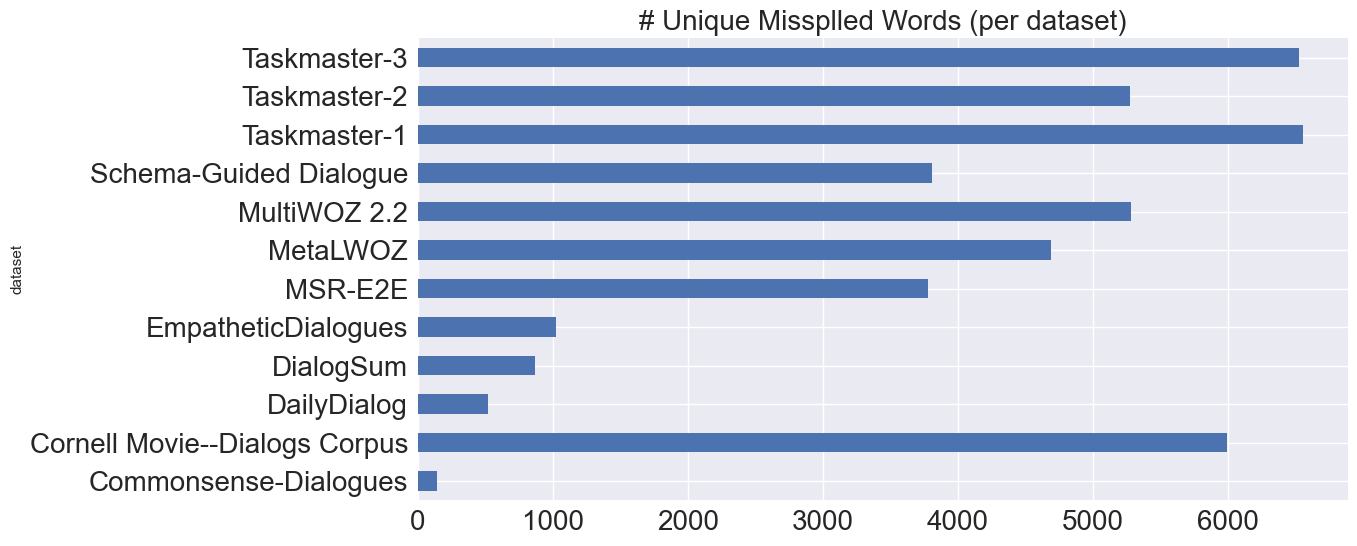

In [20]:
#@markdown Number of Unique Misspelled Words Per Dataset
misspelled_df['dataset'] = clean_df['dataset']

# we only consider words with a size of 3 or more
# this is because most misspelled words with size 2 or less are a result
# of removing the punctuation marks
min_word_length = 3

missspelled_by_dataset = misspelled_df \
  .groupby('dataset') \
  .apply(lambda df: 
         ' '.join(df.misspelled
             .apply(lambda s: ' '.join([k for k in s if len(k)>=min_word_length]))
  )
)
  
unique_missspelled_by_dataset = missspelled_by_dataset.apply(
    lambda s: len(list(set(filter(None, s.split(' ')))))
)

ax = unique_missspelled_by_dataset.plot(
    kind='barh', 
    fontsize=20,
    figsize=(12, 6),
)
ax.set_title('# Unique Missplled Words (per dataset)', fontsize=20)

C:\Users\LAPTOP\AppData\Local\Temp\ipykernel_9204\1645416308.py:17: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for ax, (dataset_name, words) in zip(axes.flat, missspelled_by_dataset.iteritems()):


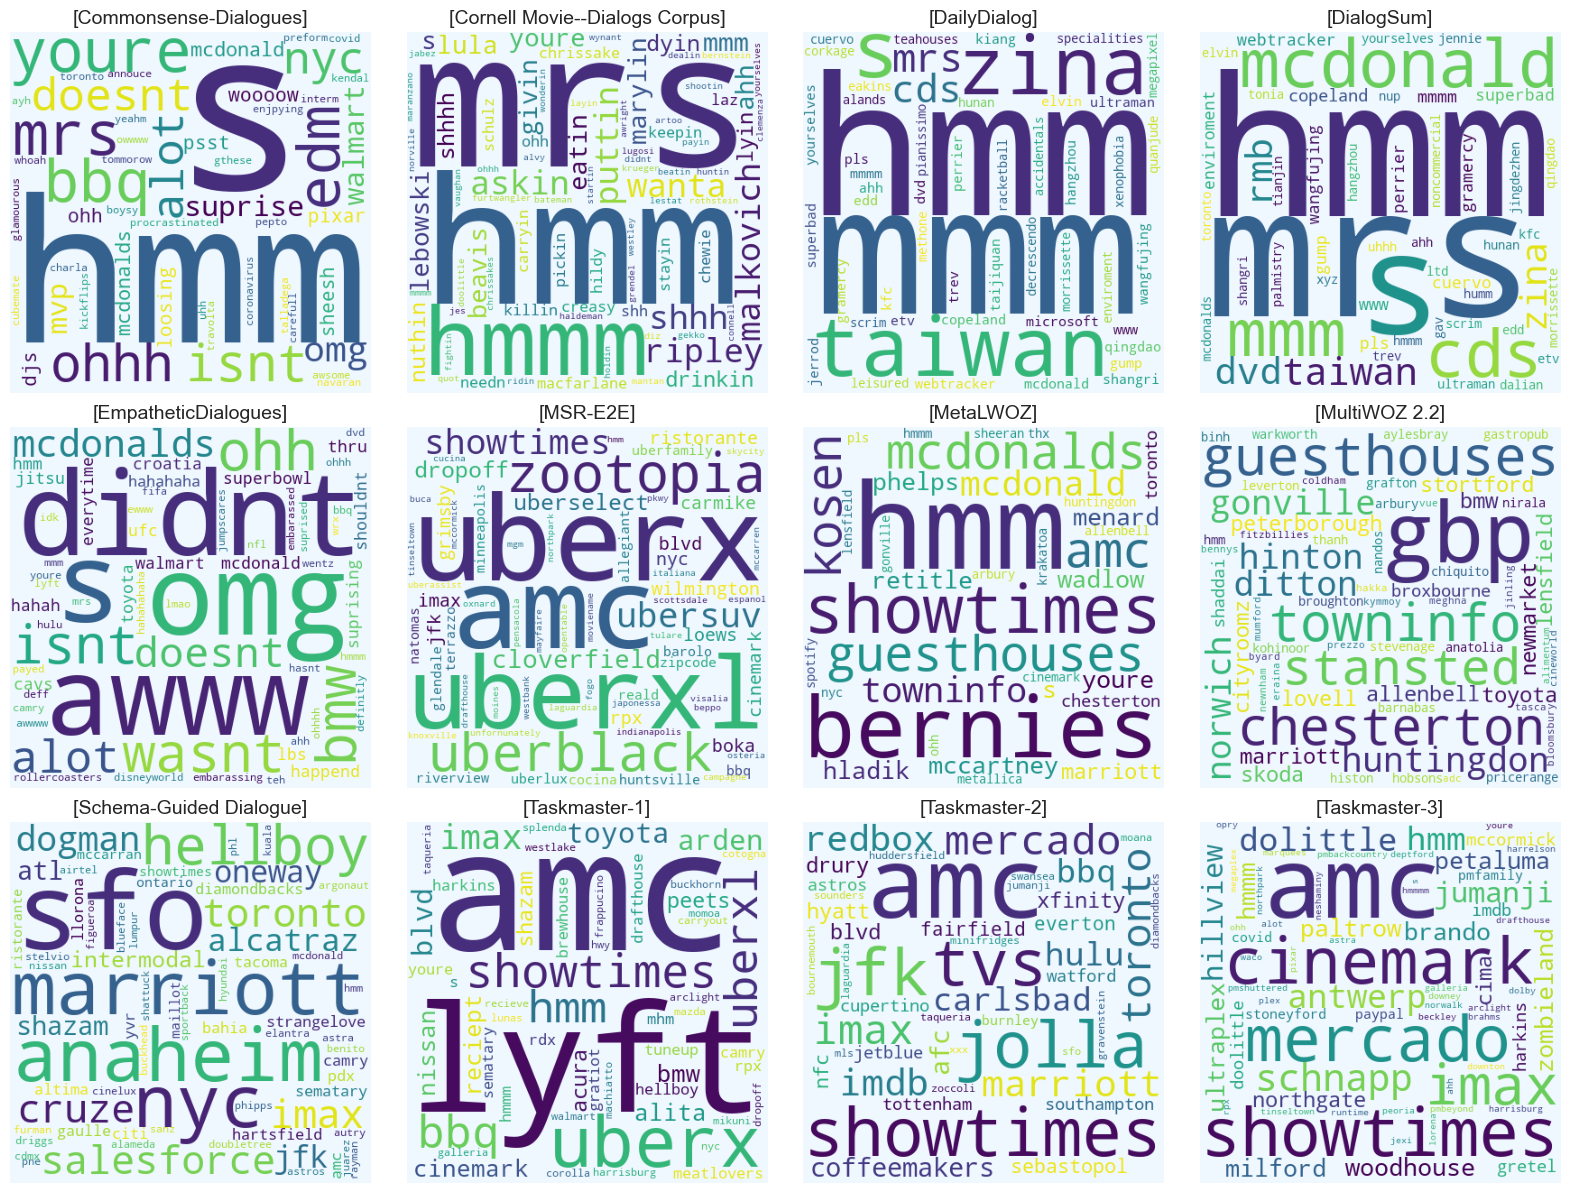

In [21]:
#@markdown Wordclouds For Misspelled Words Per Dataset

missspelled_by_dataset = misspelled_df \
  .groupby('dataset') \
  .apply(lambda df: 
         ' '.join(df.misspelled
             .apply(lambda s: ' '.join([k for k in s if len(k)>=min_word_length]))
  )
)

ncols = 4
nrows = int(np.ceil(len(missspelled_by_dataset)//4))
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(4*ncols, 4*nrows))

not_misspelled = ['afternoon', 'afterward']
correction_table = {word: "" for word in not_misspelled}
for ax, (dataset_name, words) in zip(axes.flat, missspelled_by_dataset.iteritems()):
    words = ' '.join(list(filter(None, words.split(" "))))
    for error in not_misspelled:
        words = words.replace(error, "")
    words = list(filter(None, words.split(" ")))

    wordcloud = WordCloud(
        width=400,
        height=400,
        random_state=SEED,
        background_color='aliceblue',
        relative_scaling=0.1,
        collocations=False,
        min_font_size=10).generate_from_frequencies(Counter(words)) #.generate(words)

    ax.imshow(wordcloud)
    ax.axis("off")
    ax.set_title(f"[{dataset_name}]", fontsize=14)

plt.tight_layout(pad=1)
plt.show()

Total number of unique misspelled words: 32970


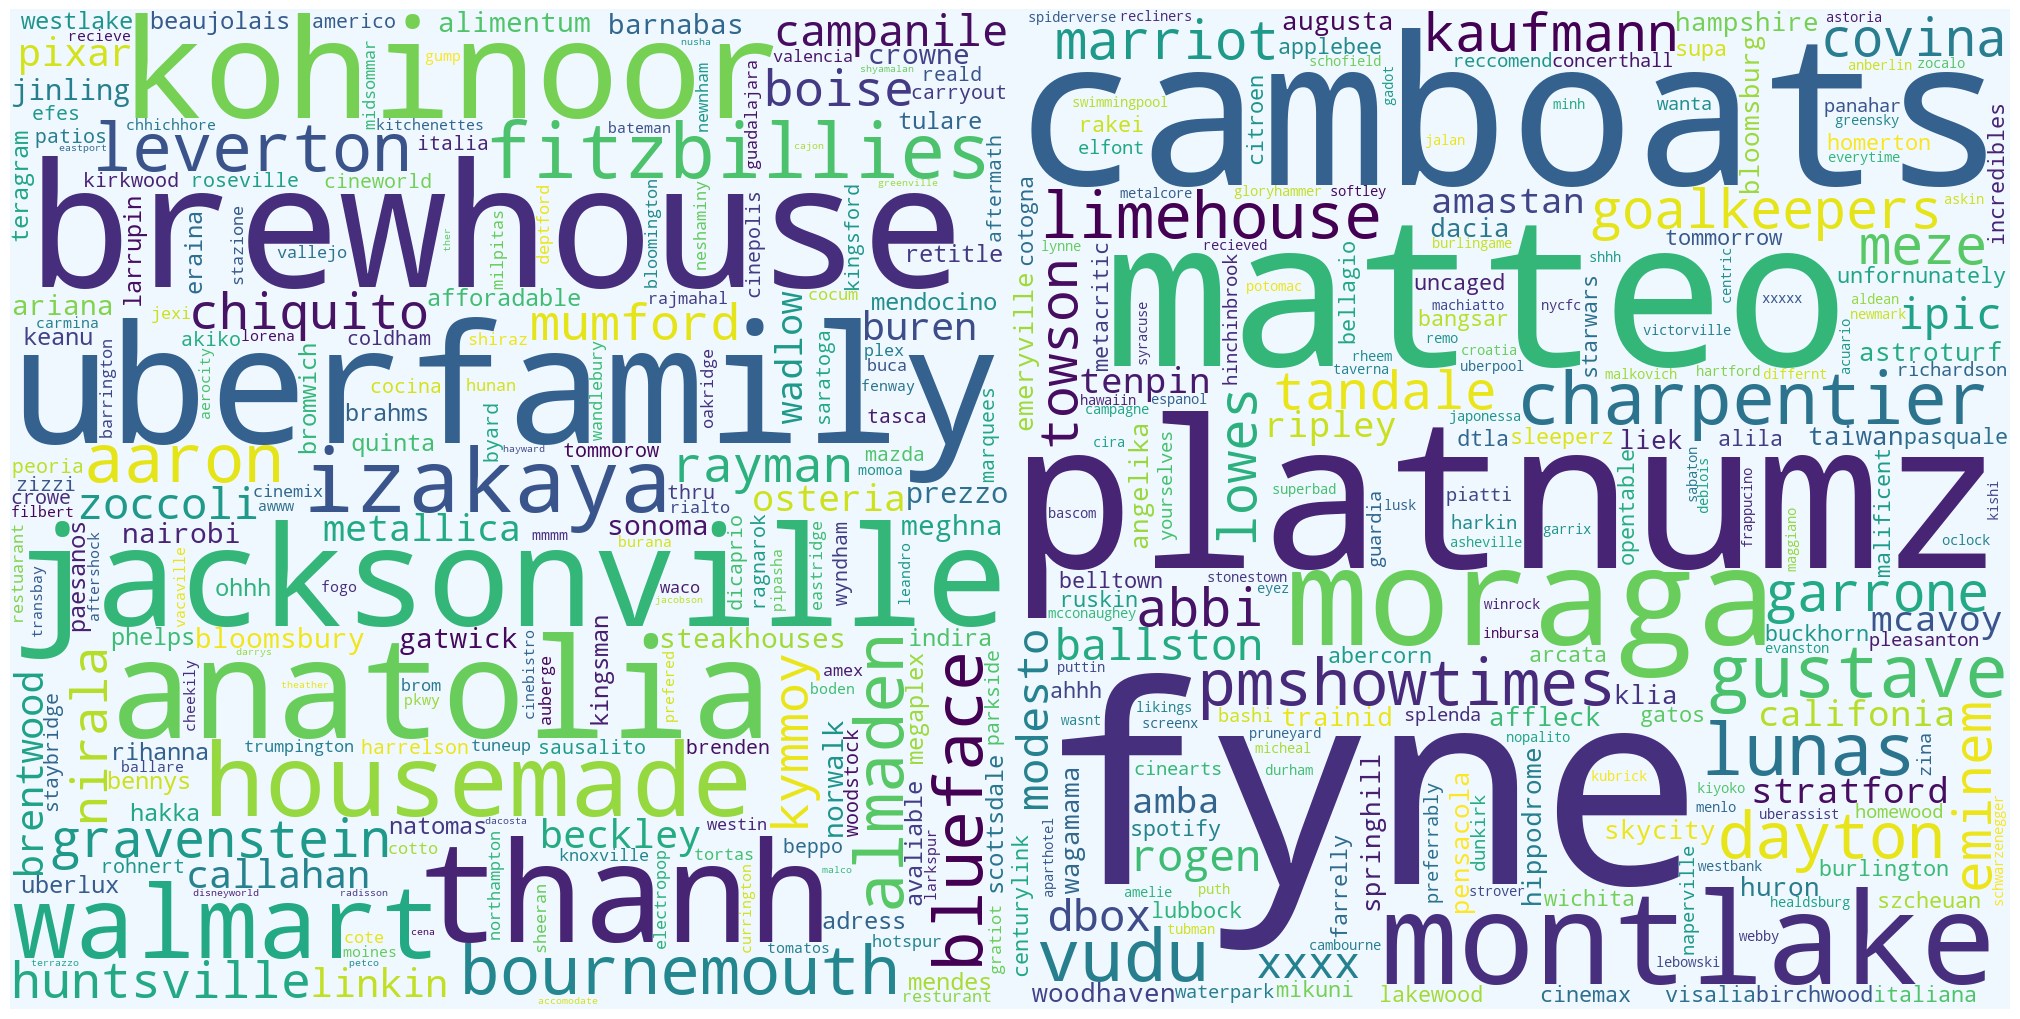

In [22]:
#@markdown Total number of Unique Misspelled Words (overall datasets) 
all_misspelled_words = list(filter(None, " ".join(missspelled_by_dataset.to_list()).split(" ")))
all_misspelled_words = [word for word in all_misspelled_words if len(word)>min_word_length]

all_misspelled_words = list(filter(lambda x: x not in not_misspelled, all_misspelled_words))

print("Total number of unique misspelled words:", len(set(all_misspelled_words)))
# Counter(all_misspelled_words).most_common(200)

# one word cloud for the whole dataset won't yield good results
# a lot of words would be missing or too small to read
# so I decided to make two word clouds with the most frequent 400 misspelled words
# I combined them into a single figure so usually no on will notice
fig, axes = plt.subplots(figsize=(20, 20), ncols=2)

size_per_wordcloud = 200
word_frequencies = Counter(all_misspelled_words)
for i, ax in enumerate(axes.ravel(),2):
    wordcloud = WordCloud(
        width=1000,
        height=1000,
        background_color='aliceblue',
        relative_scaling=0.1,
        max_words=size_per_wordcloud,
        collocations=False,
        random_state=SEED,
        min_font_size=10).generate_from_frequencies(
            {k:v for k,v in word_frequencies.most_common(
                size_per_wordcloud*i
                )[size_per_wordcloud*(i-1):]
            }
        ) #.generate(words)

    ax.imshow(wordcloud)
    ax.axis("off")

plt.gca()
# fig.suptitle(f"[Merged Dataset]", fontsize=20)
plt.tight_layout(pad=0)
plt.show()

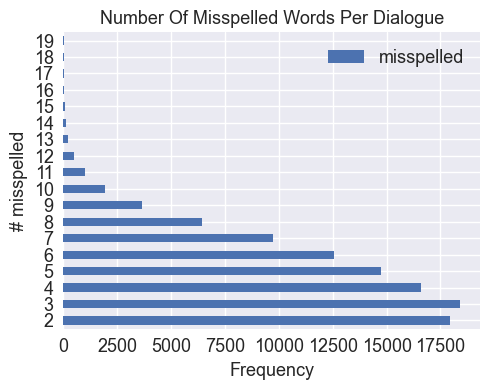

In [23]:
#@title "Number Of Misspelled Words Per Dialogue"
misspelled_df['length'] = misspelled_df.misspelled.apply(
    lambda s: len(s)
)

fontsize = 13

fig, ax = plt.subplots(figsize=(5, 4))
mask = (misspelled_df.length>1) & (misspelled_df.length<20)
misspelled_df[mask].groupby('length').count().plot(
    y='misspelled', 
    kind='barh', 
    fontsize=fontsize, 
    ax=ax
)

ax.legend(fontsize=fontsize)
ax.set_xlabel("Frequency", fontsize=fontsize)
ax.set_ylabel("# misspelled", fontsize=fontsize)#, rotation=360)

ax.set_title("Number Of Misspelled Words Per Dialogue", fontsize=fontsize)
plt.tight_layout()
plt.show()

### [Context-Based Spell Correction](https://spacy.io/universe/project/contextualSpellCheck)


There's a package in Spacy that performs spell correction on non-word errors (NWE) or resolve OOVs (out-of-vocabulary) with something meaningful given the current context. It uses the Bert model (from hugging face) to perform spell correction/resolve OOVs.


From the [source code](https://github.com/R1j1t/contextualSpellCheck/blob/88bbbb46252c534679b185955fd88c239ed548a7/contextualSpellCheck/contextualSpellCheck.py#L219) of the package:

> All the following criteria should be met for word to be misspelled
  1. Should not be in our vocab
  2. should not be a Person
  3. Should not be a number
  4. Should not be a url
  5. Should not be a space
  6. Should not be punctuation
  7. Should not be a Geopolitical Entity
  8. Should not be a Organisation

The misspelled words are masked with a token (eg [MASK]) and then the model tries to predict `n` candidates for that mask.

In [24]:
#@markdown Testing the Context-Based Spell Correction method on a random sample of dialogues
#@markdown The results don't look that great. But It's not too bad either. It can definitely do better with some tweaking.

#@markdown Note: 

#@markdown - The words colored in <font color='salmon'>(red)</font> refer to misspelled words (according to the model).
#@markdown - The words colored in <font color='lightgreen'>(green)</font> refer to the correction of those words (according to the model).
nlp = spacy.load('en_core_web_sm')

nlp.add_pipe(
    "contextual spellchecker", 
    config={"model_name": "distilbert-base-uncased"}
)

def remove_speaker_prefix(dialogue):
    # removes "#Person1#: " "#Person2#: "
    dialogue = dialogue.replace("#Person1#:", "").replace("#Person2#:", "")
    dialogue = '\n'.join([sent.strip() for sent in dialogue.split("\n")])
    return dialogue

def pprint_corrections(before: str, after:str) -> None:
    tokens1 = nlp(before)
    tokens2 = nlp(after)

    output = ""
    for t1, t2 in zip(tokens1, tokens2):
        token = t1.text
        if t1.text != t2.text:
            token = (Style.RESET_ALL
                    +Fore.RED + f"({t1.text})"
                    +Fore.GREEN + f"({t2.text})"
                    +Style.RESET_ALL
            )
        
        output += token + (" " if token != "\n" else "")

    if len(tokens2) == 0:
        output = before
    
    print(output)

sample_dialogues = clean_df.sample(n=15, random_state=SEED)
for i, dialogue in enumerate(sample_dialogues['dialogue']):
    print("Dialogue ID:", sample_dialogues.iloc[i].name)
    print("Dataset:", sample_dialogues.iloc[i]['dataset'])

    dialogue = remove_speaker_prefix(dialogue)
    doc = nlp(dialogue)
    pprint_corrections(dialogue, doc._.outcome_spellCheck)
    print("---"*40)

Dialogue ID: 75004
Dataset: Cornell Movie--Dialogs Corpus
You (hadda)(can) show up on a weekend .   This weekend .   Would n't 've even been a gun show ... for another month . 
Fucking out of order , that .   Should n't be allowed . 
------------------------------------------------------------------------------------------------------------------------
Dialogue ID: 30754
Dataset: MetaLWOZ
Hello how may I help you ? 
Hi I 'm thinking about going skiing next weekend 
ok where would you like to go skiing ? 
In the Poconos 
I am sorry it appears most ski hills will be closed next weekend there 
Will the weather be no good there next weekend ? Is that why ? 
There appears to be a (wildfire)(road) heading that direction 
Oh okay well I guess I 'll just wait until that clears up . I had my heart set on the (Poconos)(books) so nowhere else will do 
Would you like to book something further out ? 
Yes one month from today for 2 
Ok . I can book that for you 
-------------------------------------

## N-grams Analysis

In [25]:
# raise NotImplementedError

## Checking Self-Similarity Between Collected Dialogues

In [26]:
# raise NotImplementedError

# Splitting The Merged Dataset 

In [27]:
#@markdown Since the dataset is merged from multiple sources, it's not correct to just take random samples to make the train/tune/dev/test sets. The same distributions (topic distributions & source dataset distributions) need to be maintained in each split. This is mainly done to prevent the models from having a bias towards a specific dataset or topic (this WILL NOT prevent biases in general, it's just to avoid a specific type of bias). It's also to make sure that the test set contains data from the same distributions the model was trained on.
#@markdown 
#@markdown Here's how each split will be used:
#@markdown   - train split (used for training/fine-tuning models)
#@markdown <!-- - tune split (used for hyperparameter tuning only) -->
#@markdown   - dev/validation split (used to determine the best model architecture/hyperparameters)
#@markdown   - test split (used for final evaluation, there WILL NOT be any extra work on the model after testing on this one)
#@markdown 
#@markdown Also, for testing purposes, there will be three versions of the dataset:
#@markdown   - Small: 10% of the dataset
#@markdown   - Medium: 50% of the dataset
#@markdown   - Large: 100% of the dataset
#@markdown 

os.chdir(PROJECT_PATH)

OUTPUT_PATH = "DataEngineering/FinalDataset" #@param {"type": "string"}
os.makedirs(OUTPUT_PATH, exist_ok=True)
os.chdir(OUTPUT_PATH)

TRAIN_PERCENTAGE = 0.70 #@param {"type":"number"}
TEST_PERCENTAGE = 0.15 #@param {"type":"number"}
DEV_PERCENTAGE = 0.15 #@param {"type":"number"}
# TUNE_PERCENTAGE = 0.05 #@param {"type":"number"}

versions = [
    (0.10, 'small'), 
    (0.50, 'medium'),
    (1, 'large')
]

final_df = clean_df.fillna('unknown', axis=1)

sizes_df = pd.DataFrame(
    columns=['# train samples', '# test samples', '# dev samples'],
).rename_axis(index='dataset_version')

final_datasets = {
    "small": [],
    "medium": [],
    "large": [],
}

for version_size, version_name in versions:
    os.makedirs(version_name, exist_ok=True)
    # just use the train_test_split function from sklearn
    # it's smart enough to do this
    version_df = final_df

    if (version_size < 1):
        version_df, _ = train_test_split(
            final_df, 
            train_size=version_size, 
            random_state=SEED
        )

    train_df, test_df = train_test_split(
        version_df, 
        train_size=TRAIN_PERCENTAGE, 
        random_state=SEED
    )

    test_df, dev_df = train_test_split(
        test_df, 
        train_size=(TEST_PERCENTAGE/(1-TRAIN_PERCENTAGE)), 
        random_state=SEED
    )
        

    train_df.to_csv(os.path.join(version_name, "train.csv"))
    test_df.to_csv(os.path.join(version_name, "test.csv"))
    dev_df.to_csv(os.path.join(version_name, "dev.csv"))

    sizes_df.loc[version_name] = [
        train_df.shape[0], 
        test_df.shape[0], 
        dev_df.shape[0], 
    ]
    final_datasets[version_name] = [train_df, test_df, dev_df]

for f in glob.glob("./*/*",):
    print(f)
helperFunctions.pprint_df(sizes_df)
display(train_df)

.\large\dev.csv
.\large\test.csv
.\large\train.csv
.\medium\dev.csv
.\medium\test.csv
.\medium\train.csv
.\small\dev.csv
.\small\test.csv
.\small\train.csv


,# train samples,# test samples,# dev samples
dataset_version,,,
small,8K,1K,1K
medium,43K,9K,9K
large,86K,18K,18K


,dialogue,dataset,topic,subtopic1,subtopic2
16671,#Person1#:Find a general practitioner.\r\n#Per...,Schema-Guided Dialogue,Food & Drink,Restaurants,unknown
2531,#Person1#:I'm looking for a restaurant in the ...,MultiWOZ 2.2,Food & Drink,Restaurants,unknown
4688,#Person1#:I'd like help finding a hotel in Nas...,Taskmaster-2,Travel,Hotels & Accommodations,unknown
61546,#Person1#: Do you know somebody called the The...,Cornell Movie--Dialogs Corpus,Arts & Entertainment,Music & Audio,unknown
4884,#Person1#:I'm looking for a British restaurant...,MultiWOZ 2.2,Food & Drink,Restaurants,unknown
...,...,...,...,...,...
18491,#Person1#: She likes him.\r\n#Person2#: Hmm?\r...,Cornell Movie--Dialogs Corpus,Arts & Entertainment,unknown,unknown
9060,#Person1#:What is the dropoff location?\n#Pers...,MSR-E2E,Travel,unknown,unknown
13255,#Person1#:I need to make a hotel reservation.\...,Schema-Guided Dialogue,Travel,Air Travel,unknown
11845,#Person1#: Did you get Bean's ten different go...,DailyDialog,Arts & Entertainment,unknown,unknown


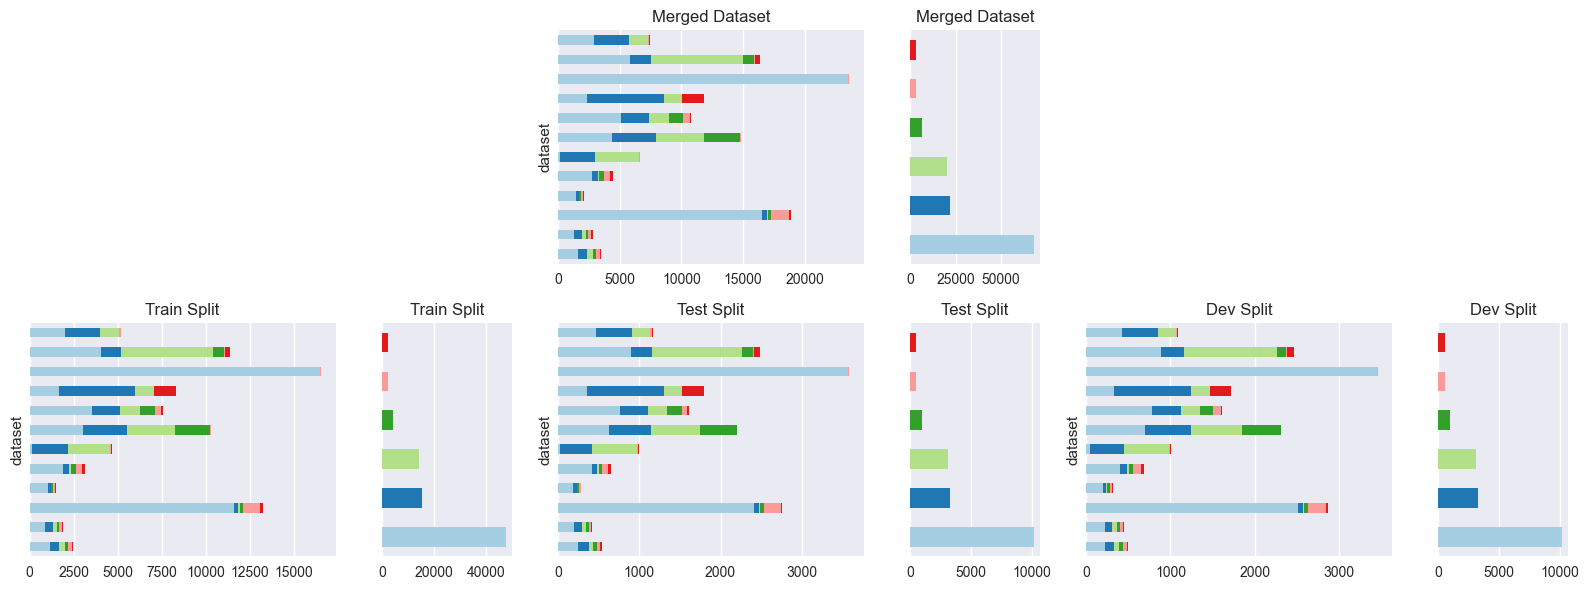

In [28]:
#@markdown ### Sanity Check (to make sure all splits have the same distributions)

fig = plt.figure(figsize=(16, 6), constrained_layout=True)

gs = GridSpec(2, 9, figure=fig)
ax1 = (fig.add_subplot(gs[0, 3:5]), fig.add_subplot(gs[0, 5:6]))

ax2 = (fig.add_subplot(gs[1, 0:2]), fig.add_subplot(gs[1, 2]))
ax3 = (fig.add_subplot(gs[1, 3:5]), fig.add_subplot(gs[1, 5]))
ax4 = (fig.add_subplot(gs[1, 6:-1]), fig.add_subplot(gs[1, -1]))

plot_df_distributions(final_df, "Merged Dataset", fig, ax1, False)
plot_df_distributions(train_df, "Train Split", fig, ax2, False)
plot_df_distributions(test_df, "Test Split", fig, ax3, False)
plot_df_distributions(dev_df, "Dev Split", fig, ax4, False)
plt.show()